## Plot of Implied volatilities

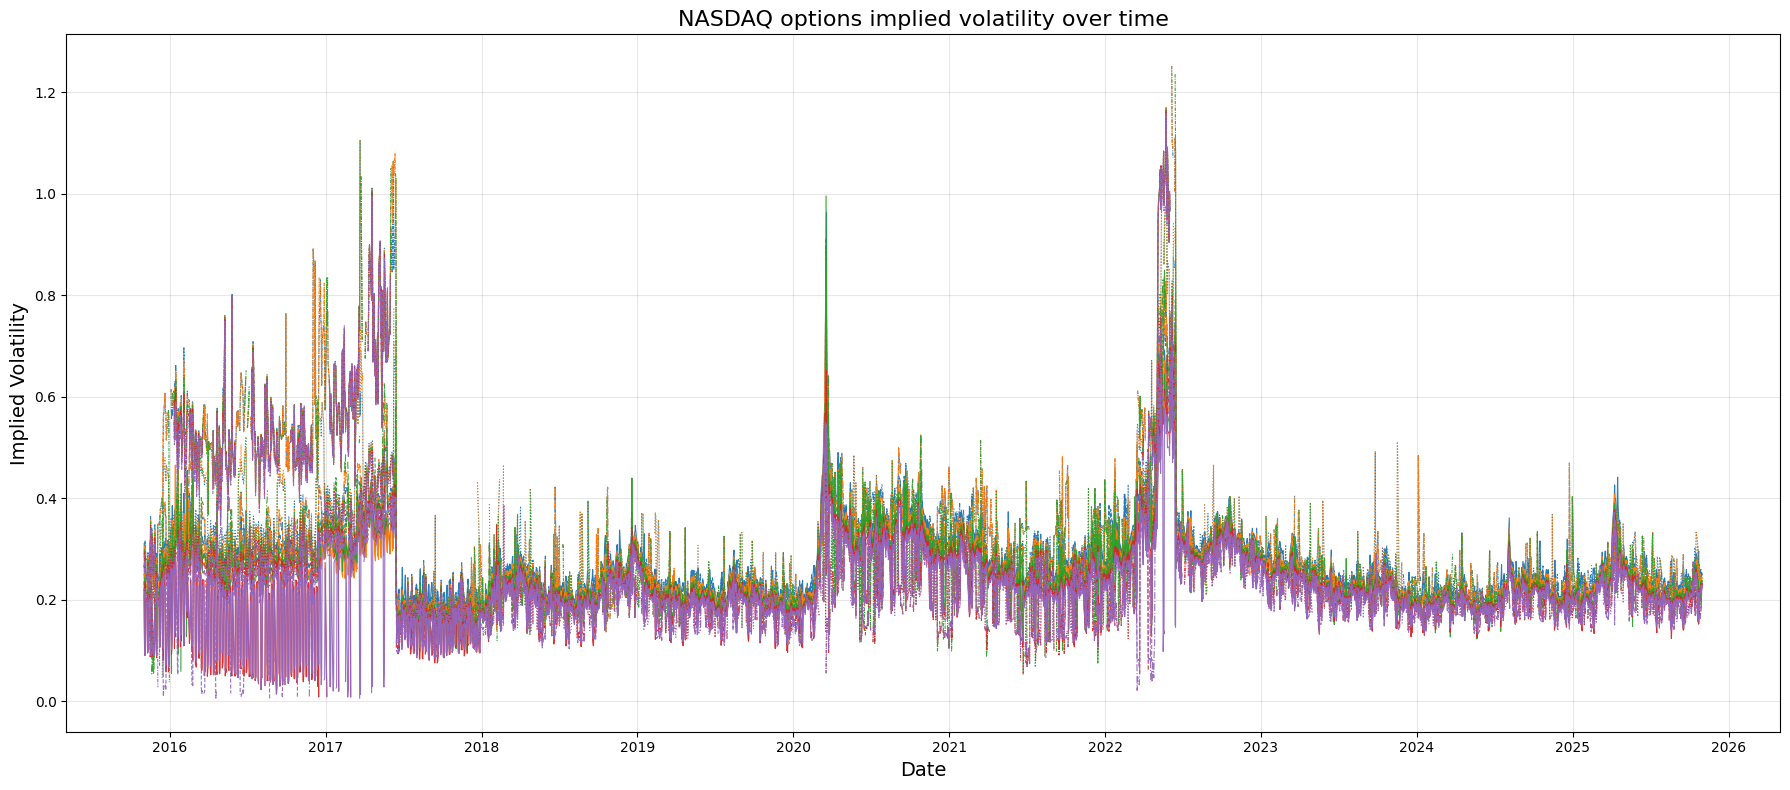

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define constants
DATA_DIR = r'C:\Mini_Project\output\final_data\data'
STRIKES = [0.9, 0.95, 1.0, 1.05, 1.1]
MATURITIES = [30, 90, 120, 180, 360]
START_DATE = datetime(2015, 11, 2)
END_DATE = datetime(2025, 10, 31)

# Generate the list of dates in the range (closed interval)
all_dates = pd.date_range(START_DATE, END_DATE, freq='B')  # Use business days if needed, else use 'D'


# Helper function to load options data, concatenate, and filter relevant columns
def load_all_options_data(data_dir, start_date, end_date):
    """
    Load all yearly option files and concatenate into one DataFrame.
    """
    all_dfs = []
    for year in range(start_date.year, end_date.year + 1):
        yearly_folder = os.path.join(data_dir, str(year))
        csv_path = os.path.join(yearly_folder, f"^NDX_options_data_{year}.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, parse_dates=['date'])
            all_dfs.append(df)
    if not all_dfs:
        raise FileNotFoundError("No options data files found in the requested range.")
    all_data = pd.concat(all_dfs, ignore_index=True)
    return all_data

# Load all data (it automatically parses dates)
options_data = load_all_options_data(DATA_DIR, START_DATE, END_DATE)

# Ensure the date column is datetime, and filter for requested date range
options_data['date'] = pd.to_datetime(options_data['date'])
options_data = options_data[(options_data['date'] >= START_DATE) & (options_data['date'] <= END_DATE)]

strike_col = 'relative_strike'
maturity_col = 'maturity_days'
implied_vol_col = 'implied_vol'

# Now: PLot all (strike, maturity) time series on one (shared) plot
import itertools

# Use a colormap with more distinct colors
cmap = plt.get_cmap("tab10")  # 10 distinct colors
# Create a custom color palette - one color per strike
strike_colors = [cmap(i) for i in range(len(STRIKES))]

plt.figure(figsize=(18, 8))

# More distinct line styles for maturities
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2))]

lines = []
labels = []

for idx_s, strike in enumerate(STRIKES):
    for idx_m, maturity in enumerate(MATURITIES):
        tol_strike = 0.0001
        tol_maturity = 0  # exact days

        relevant = options_data[
            (np.isclose(options_data[strike_col], strike, atol=tol_strike)) &
            (np.isclose(options_data[maturity_col], maturity, atol=tol_maturity))
        ].copy()

        # If there are no rows, skip
        if relevant.empty:
            continue

        relevant = relevant.sort_values("date")
        color = strike_colors[idx_s]
        linestyle = linestyles[idx_m % len(linestyles)]
        
        line, = plt.plot(
            relevant["date"],
            relevant[implied_vol_col],
            label=f'K/S={strike}, M={maturity}',
            color=color,
            linestyle=linestyle,
            linewidth=0.8,
            alpha=0.95,
        )
        lines.append(line)
        labels.append(f'K/S={strike}, M={maturity}')

plt.title("NASDAQ options implied volatility over time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "NASDAQ_options_implied_volatility_over_time.png"))
plt.show()



## Cross correlation of log-implied vols and log-returns (prices)

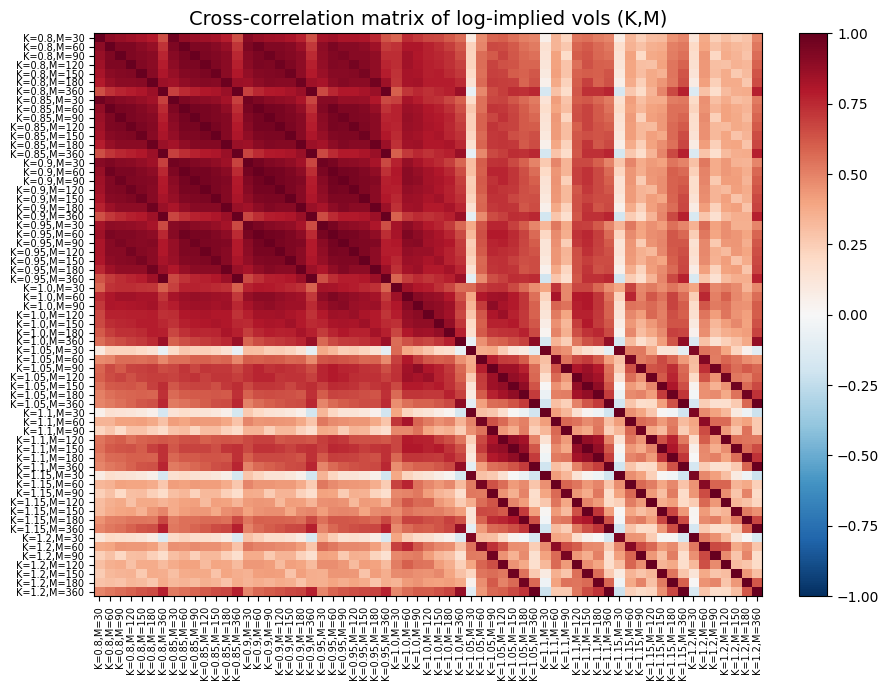

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# Define the strike and maturity sets
K_set = [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]
M_set = [30, 60, 90, 120, 150, 180, 360]

# Restrict data to the period and available sets
date_mask = (options_data["date"] >= pd.to_datetime(START_DATE)) & (options_data["date"] <= pd.to_datetime(END_DATE))
options_filtered = options_data[date_mask &
    options_data[strike_col].isin(K_set) &
    options_data[maturity_col].isin(M_set)
]

# Build time-indexed table of log-implied vols
implied_vol_pivot = options_filtered.pivot_table(
    index="date", columns=[strike_col, maturity_col], values=implied_vol_col)

log_implied_vols = np.log(implied_vol_pivot)

# Build time-indexed table of option prices for each (K,M) combination
option_price_pivot = options_filtered.pivot_table(
    index="date", columns=[strike_col, maturity_col], values="option_price")

# Calculate log-returns for each (K,M) combination
# Log-return = log(price_t) - log(price_{t-1}) = diff(log(price))
log_option_prices = np.log(option_price_pivot)
log_returns_km = log_option_prices.diff().dropna()

# Align indices of log_implied_vols and log_returns_km
common_dates = log_implied_vols.index.intersection(log_returns_km.index)
log_implied_vols_aligned = log_implied_vols.loc[common_dates]
log_returns_km_aligned = log_returns_km.loc[common_dates]

# Flatten column names for correlation matrix
log_returns_flat = log_returns_km_aligned.copy()
log_returns_flat.columns = [f"K={k},M={m}" for (k, m) in log_returns_flat.columns]

implied_vol_flat = log_implied_vols_aligned.copy()
implied_vol_flat.columns = [f"K={k},M={m}" for (k, m) in implied_vol_flat.columns]

# Compute cross-correlation matrix of log-returns (K,M)
corr_log_returns = log_returns_flat.corr()

# Also compute correlation matrix of log-implied vols (K,M)
corr_vols = implied_vol_flat.corr()

fig, axes = plt.subplots(1, 1, figsize=(9, 7))

# Plot cross-correlation matrix of log-returns (K,M)
km_labels = log_returns_flat.columns
# Use CenteredNorm to center the colormap at zero for better visibility of values near zero
norm1 = CenteredNorm(vcenter=0, halfrange=1.0)
im = axes.imshow(corr_vols.values, 
                    aspect='auto', 
                    cmap='RdBu_r', 
                    norm=norm1)
axes.set_xticks(np.arange(len(km_labels)))
axes.set_yticks(np.arange(len(km_labels)))
axes.set_xticklabels(km_labels, fontsize=7, rotation=90)
axes.set_yticklabels(km_labels, fontsize=7)
axes.set_title("Cross-correlation matrix of log-implied vols (K,M)", fontsize=14)
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.045)

# Plot correlation matrix of log-implied vols (K,M)
# im2 = axes[1].imshow(corr_vols.values, 
#                      aspect='auto', 
#                      cmap='RdBu_r', 
#                      norm=norm2)
# axes[1].set_xticks(np.arange(len(km_labels)))
# axes[1].set_yticks(np.arange(len(km_labels)))
# axes[1].set_xticklabels(km_labels, fontsize=7, rotation=90)
# axes[1].set_yticklabels(km_labels, fontsize=7)
# axes[1].set_title("Correlation matrix of log-implied vols (K,M)", fontsize=14)
# fig.colorbar(im2, ax=axes[1], orientation="vertical", fraction=0.045)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "Cross_correlation_matrix_of_log-vols.png"))
plt.show()


# Merton's Poisson Jump model

In [ ]:
"""
merton_calibration.py

Calibrate Merton jump–diffusion model parameters to option prices.

Requires:
    numpy
    scipy

Contents:
    - Black–Scholes formulas
    - Merton mixture pricing
    - Simulation methods
    - Calibration to option prices
"""

import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm
from scipy.optimize import minimize

# ============================================================
# 1. Black–Scholes pricing
# ============================================================

def bs_price_call_put(S, K, r, sigma, T, option_type='call'):
    if T <= 0:
        if option_type == 'call':
            return np.maximum(S - K, 0.0)
        else:
            return np.maximum(K - S, 0.0)

    sqrtT = np.sqrt(T)
    sigmaT = sigma * sqrtT
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / sigmaT
    d2 = d1 - sigmaT

    if option_type == 'call':
        return S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


# ============================================================
# 2. Merton mixture closed-form call price
# ============================================================

def merton_price_call(S0, K, r, sigma, lam, muJ, sigmaJ, T, Nmax=200, tol=1e-12):
    lamT = lam * T
    price = 0.0
    p_n = np.exp(-lamT)  # Poisson(0)

    for n in range(0, Nmax + 1):
        # Adjusted Black–Scholes parameters
        sigma_n = sqrt(sigma**2 + (n * sigmaJ**2) / T) if T > 0 else 0.0
        S0_n = S0 * exp(n * muJ)

        term = p_n * bs_price_call_put(S0_n, K, r, sigma_n, T, 'call')
        price += term

        # Stop when term negligible
        if abs(term) < tol:
            break

        # Update Poisson probability
        p_n = p_n * lamT / (n + 1)

    return price


# ============================================================
# 3. Full calibration to option prices
# ============================================================

def calibrate_merton_to_options(
    S0, r,
    strikes, maturities, market_prices,
    weights=None,
    initial_guess=(0.2, 0.5, -0.05, 0.2),
    bounds=((1e-4, 2.0), (1e-4, 5.0), (-1.0, 1.0), (1e-4, 2.0)),
    verbose=True
):
    """
    Calibrate parameters (sigma, lambda, muJ, sigmaJ) to option prices.

    Inputs:
        S0 : float                        spot price
        r  : float                        risk-free rate
        strikes : array                   strikes K_i
        maturities : array                maturities T_i
        market_prices : array             market call prices C_i
        weights : array or None
        initial_guess : tuple             initial parameter guess
        bounds : tuple of (low, high)     bounds for each parameter

    Returns:
        calibrated_params : dict
    """
    strikes = np.asarray(strikes)
    maturities = np.asarray(maturities)
    market_prices = np.asarray(market_prices)

    if weights is None:
        weights = np.ones_like(market_prices)
    weights = np.asarray(weights)

    # objective function
    def objective(theta):
        sigma, lam, muJ, sigmaJ = theta
        model_prices = np.array([
            merton_price_call(S0, K, r, sigma, lam, muJ, sigmaJ, T)
            for K, T in zip(strikes, maturities)
        ])
        diff = model_prices - market_prices
        return np.sum(weights * diff * diff)

    result = minimize(
        objective,
        initial_guess,
        bounds=bounds,
        method="L-BFGS-B",
        options={"maxiter": 400}
    )

    if verbose:
        print("Calibration success:", result.success)
        print("Message:", result.message)
        print("Optimal parameters:")
        print("  sigma  =", result.x[0])
        print("  lambda =", result.x[1])
        print("  mu_J   =", result.x[2])
        print("  sigma_J=", result.x[3])

    return {
        "sigma": result.x[0],
        "lambda": result.x[1],
        "muJ": result.x[2],
        "sigmaJ": result.x[3],
        "success": result.success,
        "message": result.message,
        "objective_value": result.fun
    }


# ============================================================
# 4. Example usage / test
# ============================================================

if __name__ == "__main__":

    # Example artificial market data
    S0 = 100
    r = 0.01

    strikes = np.array([80, 90, 100, 110, 120])
    maturities = np.array([0.3, 0.3, 0.3, 0.3, 0.3])

    # Generate fake market data under "true" parameters
    true_params = (0.18, 0.7, -0.08, 0.25)
    market_prices = np.array([
        merton_price_call(S0, K, r, *true_params, T)
        for K, T in zip(strikes, maturities)
    ])

    print("Market prices:", market_prices)

    # Calibrate
    calib = calibrate_merton_to_options(
        S0, r,
        strikes, maturities, market_prices,
        initial_guess=(0.2, 0.4, -0.1, 0.2)
    )
    print("Recovered parameters:", calib)